<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB # multi, binary, simgle
from wordcloud import WordCloud, STOPWORDS


In [2]:
# data from: https://kaggle.com/uciml/sms-spam-collection-dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2024-12-23 14:33:57--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.07s   

2024-12-23 14:33:57 (7.04 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# file contains some invalid chars
# depend on which version of pandas you have
# an error may be thrown
df = pd.read_csv('spam.csv', encoding='ISO-8859-1') # ISO-8859-1 is a common encoding that supports a wider range of characters than standard ASCII, helping to avoid potential errors caused by invalid characters.

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

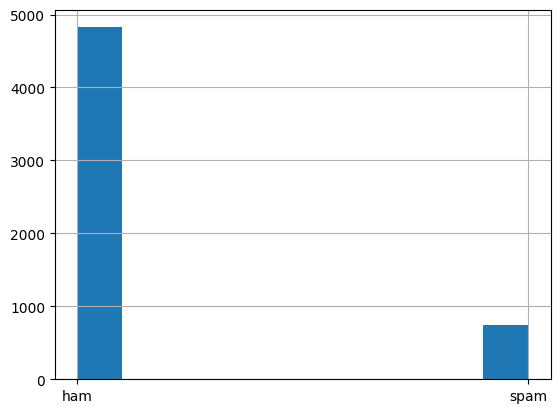

In [9]:
df['labels'].hist()

In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()

<Axes: >

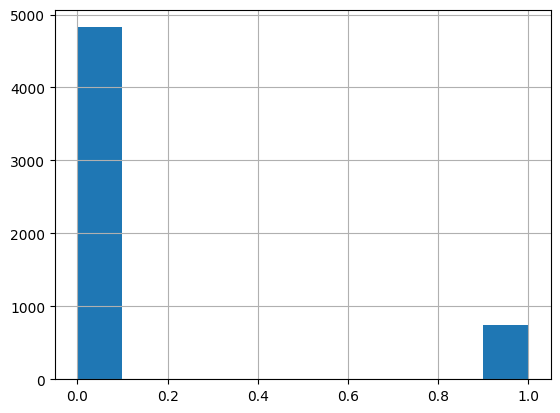

In [11]:
df['b_labels'].hist()

In [12]:
# split the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [17]:
from re import X
# try multiple ways of calculating features

# featurizer = TfidfVectorizer(decode_error='ignore')
featurizer = CountVectorizer(decode_error='ignore')

Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)


In [18]:
Xtrain

<3733x6976 sparse matrix of type '<class 'numpy.int64'>'
	with 49521 stored elements in Compressed Sparse Row format>

In [19]:
# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.994106616662202
test score: 0.9853181076672104


In [20]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print('train F1', f1_score(Ytrain, Ptrain))
print('test F1', f1_score(Ytest, Ptest))
print('train confusion matrix', confusion_matrix(Ytrain, Ptrain)) # plot a confusin matrix

train F1 0.9778225806451613
test F1 0.944558521560575
train confusion matrix [[3226    8]
 [  14  485]]


In [21]:
Prob_train = model.predict_proba(Xtrain)[:, 1]
Prob_test = model.predict_proba(Xtest)[:, 1]
print('train AUC', roc_auc_score(Ytrain, Prob_train))
print('test AUC', roc_auc_score(Ytest, Prob_test))

train AUC 0.993839875173972
test AUC 0.9791062630522495


In [23]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3226,    8],
       [  14,  485]])

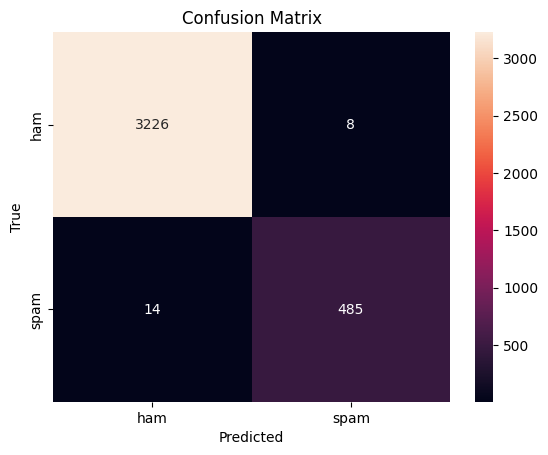

In [26]:
# render nice looking confusin matrix
def plot_cm(cm):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='d')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.set_title('Confusion Matrix')

plot_cm(cm)


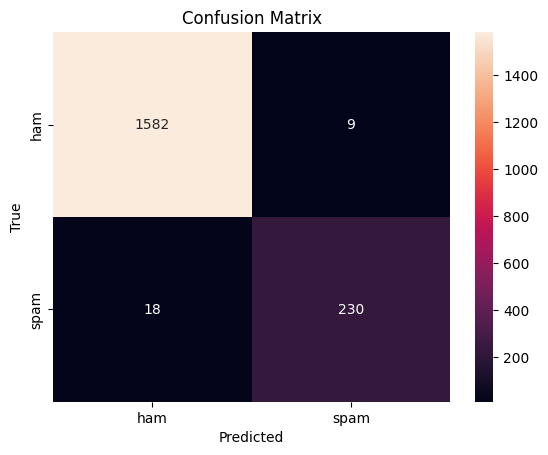

In [27]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

In [28]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '

  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

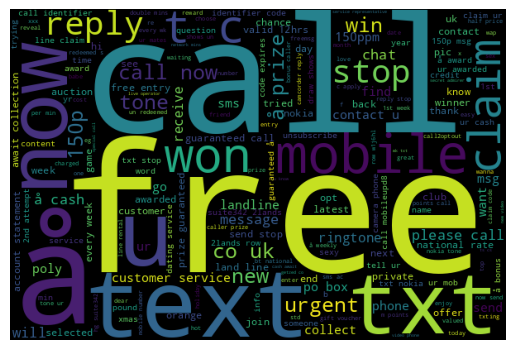

In [29]:
visualize('spam')

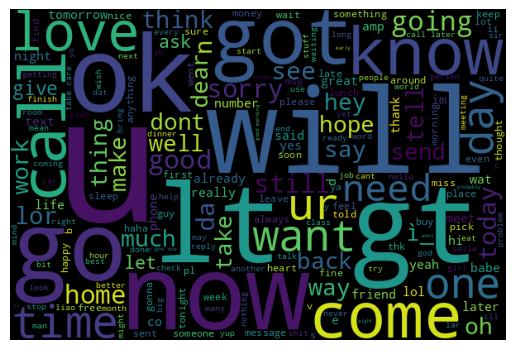

In [30]:
visualize('ham')

In [32]:
# see what we're getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [33]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO
0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\"
FreeMsg:Feelin kinda lnly hope u like 2 keep me company! Jst got a cam moby wanna c my pic?Txt or reply DATE to 82242 Msg150p 

In [34]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

No calls..messages..missed calls
Finally the match heading towards draw as your prediction.
No calls..messages..missed calls
Waiting for your call.
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Total video converter free download type this in google search:)
No calls..messages..missed calls
Madam,regret disturbance.might receive a reference check from DLF Premarica.kindly be informed.Rgds,Rakhesh,Kerala.
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Gettin rdy to ship comp
Have you laid your airtel line to rest?
Received, understood n acted upon!
I liked the new mobile
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
